In [2]:
import pandas as pd
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

# Suppress warnings`
warnings.filterwarnings("ignore")

In [3]:
import imp

In [5]:
import xy

# $因子描述：换手多空动量（Turnover Long-Short Momentum）$

***计算每个标的换手率多头组合的收益率，即标的放量收益率和缩量收益率之差***  
从个股上看，换手多空动量是一个空头指标，这意味着过去20日内，**出现放量下跌且缩量上涨的标的更有可能在次日上涨**，而在指数强弱上体现了相反的规律，以此为切入点改进“个股 —— 指数”的映射方式。

1. 数据：股票日线行情、换手率  
2. 滚动20日，使用换手率最高的5日，和换手最低的五日收益率作为样本，分别计算其收益率均值得到 arr5 和 arr1；
3. arr5-arr1得到换手多空动量。
4. **在映射到指数的过程中，剔除中间噪声标的**

## 计算

In [6]:
rwr = xy.rolling_window(xy.rets,20)
rwt_rank = np.argsort(xy.rolling_window(xy.turns,20),axis=2)

### 先跌后涨

In [21]:
arr5 = []
arr1 = []
weights = []
for i0, j0 in tqdm(zip(range(rwt_rank.shape[0]),range(rwr.shape[0]))):
    st_arr5 = []
    st_arr1 = []
    weights_arr1 = []
    for i1, j1 in zip(range(rwt_rank.shape[1]),range(rwr.shape[1])):
        st_sorted_ret = rwr[j0][j1][rwt_rank[i0][i1]]
        
        # 成交量最高的5个收益率
        st_arr5.append(np.nanmean(st_sorted_ret[-5:]))
        
        # 成交量最小的5个收益率
        st_arr1.append(np.nanmean(st_sorted_ret[:5]))
        
        # 以先后顺序作为权重： rwt_rank[i0][i1][-5:].sum() 小，则说明放量在前， 否则放量在后
        weights_arr1.append(rwt_rank[i0][i1][-5:].sum() / rwt_rank[i0][i1][:5].sum())

    arr5.append(st_arr5)
    arr1.append(st_arr1)
    weights.append(weights_arr1)

4752it [05:40, 13.94it/s]


In [9]:
rwr[j0][j1]

array([        nan, -0.01498123, -0.0190114 , -0.03359173,  0.00802136,
       -0.02055699, -0.00609349,  0.00885564,  0.0364619 ,  0.00130288,
       -0.10019512,  0.        ,  0.04266089, -0.00832186,  0.00699293,
       -0.0041666 , -0.0244072 ,  0.00500347, -0.01137977,  0.0021583 ])

In [18]:
rwt_rank[i0][i1][-5:]

array([12, 10,  1,  4,  0], dtype=int64)

In [19]:
rwt_rank[i0][i1][:5]

array([ 6, 19, 18, 15, 17], dtype=int64)

In [17]:
rwt_rank[i0][i1][-5:].sum()

27

In [8]:
st_sorted_ret

array([-0.00609349,  0.0021583 , -0.01137977, -0.0041666 ,  0.00500347,
        0.0364619 , -0.00832186,  0.00885564, -0.0244072 , -0.03359173,
        0.00699293,  0.        , -0.02055699,  0.00130288, -0.0190114 ,
        0.04266089, -0.10019512, -0.01498123,  0.00802136,         nan])

In [39]:
TR5_df = pd.DataFrame(np.array(arr5),index = xy.rets.index,columns = xy.rets.columns[19:])
TR1_df = pd.DataFrame(np.array(arr1),index = xy.rets.index,columns = xy.rets.columns[19:])
weights_df = pd.DataFrame(np.array(weights),index = xy.rets.index,columns = xy.rets.columns[19:])
New_TSR1 = (((TR5_df-TR5_df.mean())/TR5_df.std() - (TR1_df-TR1_df.mean())/TR1_df.std()) * weights_df).shift(1,axis=1)

-0.2618410111907087
1 359.97635467980297
2 360.46453201970445
3 360.3423645320197
4 360.4817733990148
5 360.6064039408867
6 360.2527093596059
7 360.37635467980294
8 360.4477832512315
9 360.3591133004926
10 360.8901477832512


<Axes: >

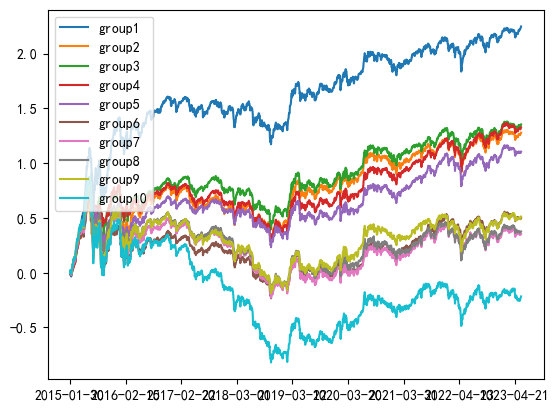

In [32]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1,
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

In [29]:
org_New_TSR1_idx = xy.read_Factor(xy.trd_dates,'New_TSR1',df=New_TSR1)#New_TSR1[(New_TSR1.rank()>4000)|(New_TSR1.rank()<1000)]

0.04934954002330639
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

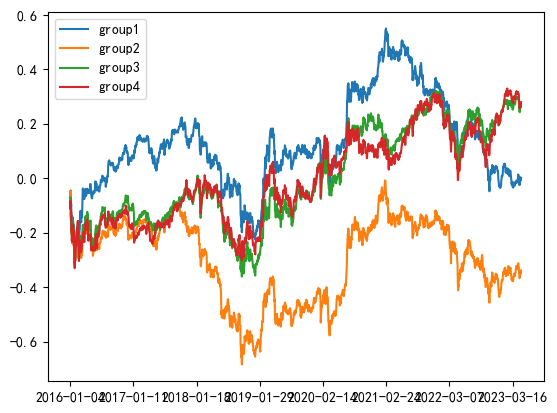

In [30]:
# 分组收益率
xy.cal_rate_group(
    org_New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

0.06131312555025661
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

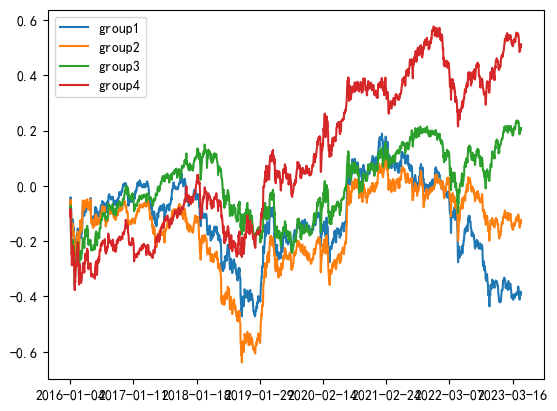

In [211]:
# 分组收益率
xy.cal_rate_group(
    org_New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

In [45]:
New_TSR1.loc[~New_TSR1.index.isin(xy.weights300.index | xy.weights50.index | xy.weights500.index | xy.weights1000.index)]

,2015-01-30,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-09,2015-02-10,2015-02-11,2015-02-12,...,2023-05-24,2023-05-25,2023-05-26,2023-05-29,2023-05-30,2023-05-31,2023-06-01,2023-06-02,2023-06-05,2023-06-06
000004.SZ,NaN,1.861100,1.708738,0.383414,0.348052,0.186158,0.811134,0.789261,0.512541,0.338088,...,-0.602945,-0.532830,-0.546093,-0.640253,-0.684736,-1.321801,-2.257484,-3.788674,-5.924445,-5.362347
000007.SZ,NaN,-1.100544,-1.201437,-3.558184,-4.354856,-3.239308,-5.505962,-4.131488,-4.480108,-4.644572,...,8.268128,8.375387,8.991101,10.015940,12.070466,14.446722,5.098865,6.613980,1.553172,-0.360207
000017.SZ,NaN,0.891897,0.756420,0.590289,0.298249,-0.069838,-0.280297,0.248096,0.347556,0.153070,...,0.006458,0.110216,0.081544,0.241730,0.087864,0.090172,-0.046424,-0.565528,-0.797695,-0.466339
000020.SZ,NaN,-0.559214,-0.560731,-0.473462,-0.477654,-0.523858,-0.582499,-0.593014,-0.534185,-0.435112,...,-1.131394,-1.270907,-1.077774,-1.473671,-2.613071,-1.515208,1.299936,0.178104,-0.365608,-0.336791
000023.SZ,NaN,0.256351,-0.135706,-0.768026,-0.539033,-1.099719,-1.194571,-1.125187,-1.037995,-1.096029,...,5.496337,5.555153,4.319797,4.420299,4.672608,3.401265,3.422548,4.256271,0.917182,-0.030966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688768.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.552500,-0.583107,-0.513547,-0.500240,-0.450283,-0.359931,-0.430284,-0.347357,-0.529545,-0.722943
688786.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.182430,-0.171805,-0.134416,-0.364664,-0.365674,-0.618924,-0.618591,-0.539684,-0.626751,2.141403
688787.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.726607,2.723277,2.691598,1.777974,1.267685,1.203824,1.148071,1.944113,1.913006,1.853296
688793.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.358554,-0.152035,-1.280819,0.443914,0.484845,0.601590,0.744265,0.931131,-1.377761,-1.119762


-0.22664536931828014
1 104.35418719211823
2 104.7743842364532
3 104.69458128078817
4 104.80738916256158
5 104.89556650246305
6 104.6024630541872
7 104.71576354679803
8 104.78620689655172
9 104.68275862068965
10 105.17635467980296


<Axes: >

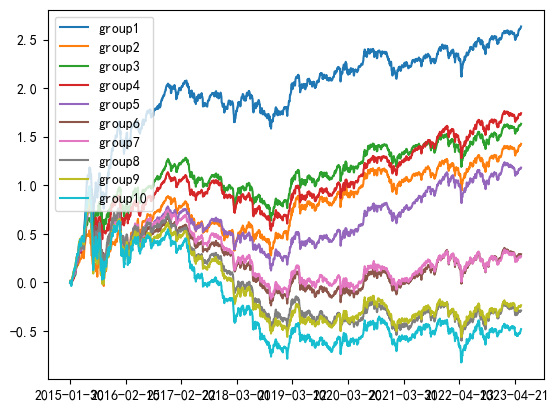

In [33]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[~New_TSR1.index.isin(xy.weights300.index | xy.weights50.index | xy.weights500.index | xy.weights1000.index)],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

-0.1874158147846354
1 104.35418719211823
2 104.7743842364532
3 104.69458128078817
4 104.80738916256158
5 104.89556650246305
6 104.6024630541872
7 104.71576354679803
8 104.78620689655172
9 104.68275862068965
10 105.17635467980296


<Axes: >

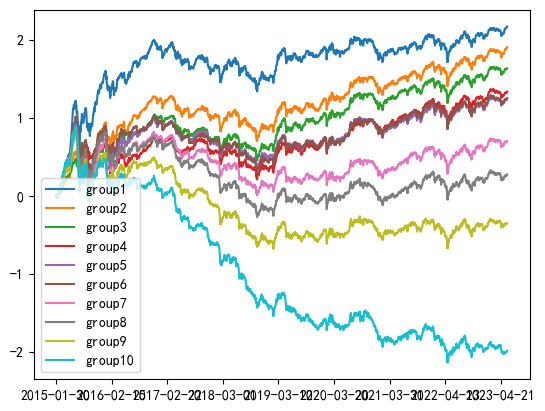

In [205]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[~New_TSR1.index.isin(xy.weights300.index | xy.weights50.index | xy.weights500.index | xy.weights1000.index)],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

-0.13448190460653503
1 255.2463054187192
2 255.71625615763546
3 255.5832512315271
4 255.71724137931034
5 255.86453201970443
6 255.5192118226601
7 255.60098522167488
8 255.69950738916256
9 255.6
10 256.1605911330049


<Axes: >

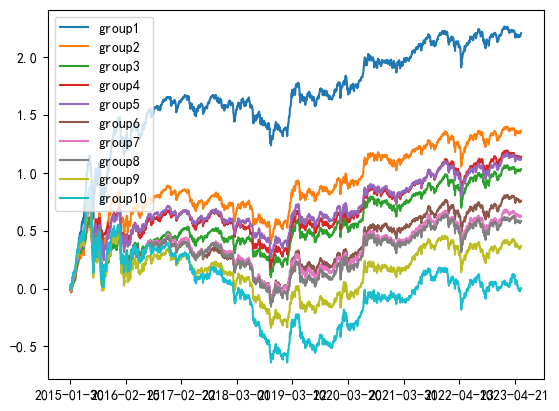

In [209]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1.loc[New_TSR1.index.isin(xy.weights300.index | xy.weights50.index | xy.weights500.index | xy.weights1000.index)],
    xy.rets,
    group_num=10,
    masks=1
).cumsum().plot()

In [40]:
New_TSR1_idx = xy.read_Factor(xy.trd_dates,'New_TSR1',df=New_TSR1[(New_TSR1.rank()>3900)|(New_TSR1.rank()<1100)])#New_TSR1[(New_TSR1.rank()>4000)|(New_TSR1.rank()<1000)]

In [41]:
RR = New_TSR1[(New_TSR1.rank()>3900)|(New_TSR1.rank()<1100)].loc[:,'2016-01-04':]

In [42]:
(RR*(xy.weights50/xy.weights50)).count().mean()

10.052164261931187

In [43]:
(RR*(xy.weights1000/xy.weights1000)).count().mean()

221.88050314465409

0.04060156216708429
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

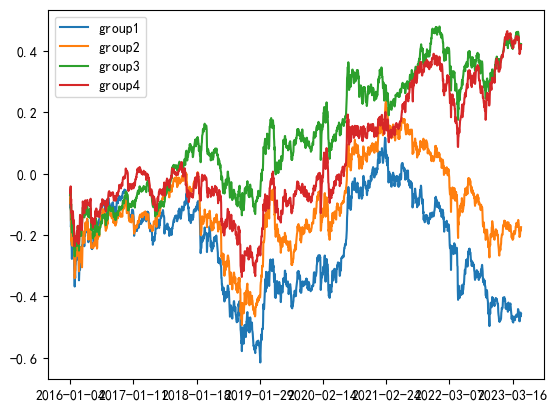

In [44]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

0.05259600029660905
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

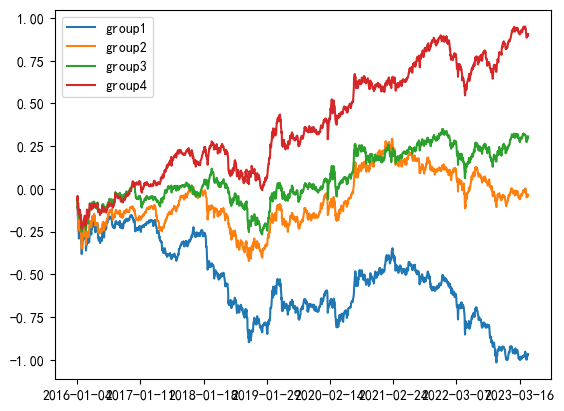

In [169]:
# 分组收益率
xy.cal_rate_group(
    New_TSR1_idx,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

954.0
yoy: 0.21661396723712043 
 mdd: -0.2391896567353189 
 sharpe: 1.3335875558113015 
 rankIC: 0.08601444517399869 
 rankIR: 0.08630606180562908 
 win%: 0.5430072225869993 
 gain_loss%: -1.0485881126722856


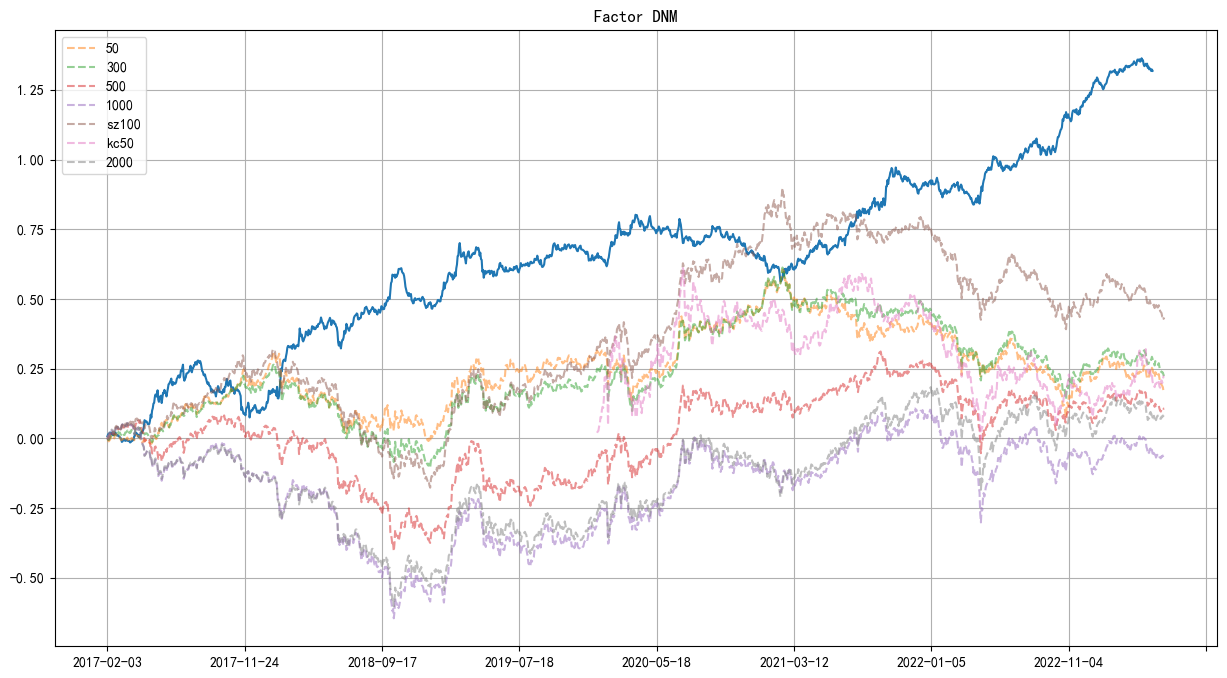

In [259]:
# 单因子强弱
DNM_select, DNM_rets = xy.single_Factor_backtest(
    New_TSR1_idx.loc[['50','500'],'2017-01-28':],# ['50','1000']
    xy.Index_rets.loc[:,'2017-01-28':],
    _side=1,
    fee=0.000,
    name='DNM'
)

In [217]:
New_TSR1_idx

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-04-21,2023-04-24,2023-04-25,2023-04-26,2023-04-27,2023-04-28,2023-05-04,2023-05-05,2023-05-08,2023-05-09
50,1.162610,1.178631,1.071053,1.074626,1.172423,1.285050,1.310740,1.336981,1.133745,1.127067,...,-1.403125,-1.293744,-1.175258,-1.489783,-1.418608,-1.378618,-1.321552,-0.932959,0.169829,-0.659408
300,0.279121,0.345265,0.455569,0.425751,0.317748,0.176470,0.047593,0.070889,0.265621,0.245809,...,0.334108,0.242778,0.428628,0.405793,0.106269,-0.044465,-0.009263,-0.164370,1.346187,-0.764973
500,-0.205534,-0.355443,-0.273406,-0.231368,-0.290028,-0.377569,-0.256579,-0.374990,-0.123074,-0.083570,...,0.117248,-0.072439,-0.387053,0.422912,0.416233,0.505567,0.236524,1.414836,-0.827962,1.407017
1000,-1.236198,-1.168453,-1.253216,-1.269009,-1.200143,-1.083950,-1.101754,-1.032880,-1.276292,-1.289307,...,0.951769,1.123405,1.133683,0.661078,0.896107,0.917517,1.094291,-0.317506,-0.688054,0.017364


In [517]:
import jqdatasdk
jqdatasdk.auth(username='13602599243',password='JoinQuant897617209')

auth success 


In [507]:
new_idx = []
for i in xy.weights1000.index:
    if i[-2:] == 'SZ':
        new_idx.append(i[:-3]+'.XSHE')
    else:
        new_idx.append(i[:-3]+'.XSHG')

['000005.XSHE',
 '000006.XSHE',
 '000008.XSHE',
 '000010.XSHE',
 '000011.XSHE',
 '000014.XSHE',
 '000016.XSHE',
 '000018.XSHE',
 '000019.XSHE',
 '000025.XSHE',
 '000028.XSHE',
 '000029.XSHE',
 '000030.XSHE',
 '000032.XSHE',
 '000034.XSHE',
 '000035.XSHE',
 '000036.XSHE',
 '000038.XSHE',
 '000040.XSHE',
 '000042.XSHE',
 '000048.XSHE',
 '000049.XSHE',
 '000055.XSHE',
 '000056.XSHE',
 '000058.XSHE',
 '000059.XSHE',
 '000061.XSHE',
 '000065.XSHE',
 '000070.XSHE',
 '000088.XSHE',
 '000089.XSHE',
 '000090.XSHE',
 '000096.XSHE',
 '000150.XSHE',
 '000151.XSHE',
 '000153.XSHE',
 '000155.XSHE',
 '000158.XSHE',
 '000159.XSHE',
 '000301.XSHE',
 '000403.XSHE',
 '000404.XSHE',
 '000407.XSHE',
 '000409.XSHE',
 '000410.XSHE',
 '000416.XSHE',
 '000419.XSHE',
 '000422.XSHE',
 '000423.XSHE',
 '000426.XSHE',
 '000428.XSHE',
 '000429.XSHE',
 '000488.XSHE',
 '000498.XSHE',
 '000503.XSHE',
 '000506.XSHE',
 '000507.XSHE',
 '000514.XSHE',
 '000516.XSHE',
 '000517.XSHE',
 '000518.XSHE',
 '000520.XSHE',
 '000521

In [189]:
Index_turnover = pd.concat([
    (xy.turns*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (xy.turns*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (xy.turns*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (xy.turns*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).shift(1).T

In [179]:
Index_OrgMom = pd.concat([
    (Orig_Mom*xy.weights50).dropna(how='all',axis=1).sum().rename('50'),
    (Orig_Mom*xy.weights300).dropna(how='all',axis=1).sum().rename('300'),
    (Orig_Mom*xy.weights500).dropna(how='all',axis=1).sum().rename('500'),
    (Orig_Mom*xy.weights1000).dropna(how='all',axis=1).sum().rename('1000')
],axis=1).T

In [388]:
def get_ovn_money_mom(ser):
    # 隔夜成交量,昨日最后5分钟量
    fore_ovn_money = pd.Series(np.nansum(xy.rolling_window(ser.money,5)[235::240],axis=1),ser[::240].index.map(lambda x: str(x)[:10]))

    # 隔夜动量
    open1min50 = ser[::240].open
    close1min50 = ser[239::240].close
    
    open1min50.index = open1min50.index.map(lambda x:str(x)[:10])
    close1min50.index = close1min50.index.map(lambda x:str(x)[:10])
    
    ovn_mom = (open1min50/close1min50.shift(1) - 1)
    
    return fore_ovn_money, ovn_mom

In [85]:
def tov_rank(x):
    xrk = x.rank()
    return list(xrk)

In [421]:
def inraday_mom(
    idx_name,
    Index_turnover,
    ret,
    winsize
):
    TRs1 = []
    TRs2 = []
    TRs3 = []
    TRs4 = []
    TRs5 = []
    dts = []
    for _, win in enumerate(Index_turnover.T[idx_name].rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = ret.T[idx_name][_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        TRs2.append(rt[(rk >= (winsize/5)+1)&(rk < 2*(winsize/5)+1)].mean())
        TRs3.append(rt[(rk >= 2*(winsize/5)+1)&(rk < 3*(winsize/5)+1)].mean())
        TRs4.append(rt[(rk >= 3*(winsize/5)+1)&(rk < 4*(winsize/5)+1)].mean())
        TRs5.append(rt[rk >= 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts),pd.Series(TRs2,dts),pd.Series(TRs3,dts),pd.Series(TRs4,dts),pd.Series(TRs5,dts)

In [421]:
def inraday_mom_all1(
    tov,
    winsize=20
):
    TRs1 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs1.append(rt[rk < (winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs1,dts)

def inraday_mom_all5(
    tov,
    winsize
):
    TRs5 = []
    dts = []
    for _, win in enumerate(tov.rolling(winsize,min_periods=winsize)):
        if _ < winsize-1:
            # print(_)
            continue

        rk = win.rank()
        rt = xy.ret[_-winsize+1:_+1]
        TRs5.append(rt[rk > 4*(winsize/5)+1].mean())
        dts.append(rt.index[-1])
        
    return pd.Series(TRs5,dts)

In [ ]:
trs50_1,trs50_2,trs50_3,trs50_4,trs50_5 = inraday_mom('50',Index_turnover,xy.Index_rets,20)
trs300_1,trs300_2,trs300_3,trs300_4,trs300_5 = inraday_mom('300',Index_turnover,xy.Index_rets,20)
trs500_1,trs500_2,trs500_3,trs500_4,trs500_5 = inraday_mom('500',Index_turnover,xy.Index_rets,20)
trs1000_1,trs1000_2,trs1000_3,trs1000_4,trs1000_5 = inraday_mom('1000',Index_turnover,xy.Index_rets,20)

In [486]:
TSR5 = pd.concat([
    trs50_5.rename('50'),
    trs300_5.rename('300'),
    trs500_5.rename('500'),
    trs1000_5.rename('1000')
],axis=1).T

TSR1 = pd.concat([
    trs50_1.rename('50'),
    trs300_1.rename('300'),
    trs500_1.rename('500'),
    trs1000_1.rename('1000')
],axis=1).T

New_TSR = (TSR5 - TSR5.mean())/TSR5.std() - (TSR1 - TSR1.mean())/TSR1.std()

### 隔夜动量

#### 计算

In [399]:
fore_ovn_money50, ovn_mom50 = get_ovn_money_mom(xy.IndexMin50jq)
fore_ovn_money300, ovn_mom300 = get_ovn_money_mom(xy.IndexMin300jq)
fore_ovn_money500, ovn_mom500 = get_ovn_money_mom(xy.IndexMin500jq)
fore_ovn_money1000, ovn_mom1000 = get_ovn_money_mom(xy.IndexMin1000jq)

In [403]:
fore_ovn_money

,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-12,2009-01-13,2009-01-14,2009-01-15,2009-01-16,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,NaN,8.250600e+08,8.135700e+08,7.307400e+08,6.344200e+08,6.769100e+08,5.158634e+08,4.247900e+08,1.107980e+09,6.541400e+08,...,1.991171e+09,1.458768e+09,1.271485e+09,1.599953e+09,1.657399e+09,1.008896e+09,1.180294e+09,1.028243e+09,1.299600e+09,1.248882e+09
300,NaN,1.828710e+09,2.013940e+09,1.861210e+09,1.489030e+09,1.728810e+09,1.483170e+09,1.355240e+09,2.623140e+09,1.991300e+09,...,7.481325e+09,6.114054e+09,5.458529e+09,6.106284e+09,6.045430e+09,4.686187e+09,5.080390e+09,5.039014e+09,5.276711e+09,4.504931e+09
500,NaN,7.935900e+08,9.751000e+08,9.623200e+08,8.130200e+08,9.227900e+08,8.786500e+08,8.295500e+08,1.235610e+09,1.157390e+09,...,4.312992e+09,3.974655e+09,3.701919e+09,4.238894e+09,3.918296e+09,3.400174e+09,3.324875e+09,3.491412e+09,3.938973e+09,3.235583e+09
1000,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.445847e+09,4.811376e+09,4.712436e+09,4.915385e+09,4.815079e+09,4.122559e+09,4.339571e+09,4.773196e+09,4.808558e+09,4.283948e+09


In [404]:
fore_ovn_money = pd.concat([
    fore_ovn_money50.rename('50'),
    fore_ovn_money300.rename('300'),
    fore_ovn_money500.rename('500'),
    fore_ovn_money1000.rename('1000')
],axis=1).shift(1).T

In [405]:
fore_ovn_mom

,2009-01-05,2009-01-06,2009-01-07,2009-01-08,2009-01-09,2009-01-12,2009-01-13,2009-01-14,2009-01-15,2009-01-16,...,2023-05-10,2023-05-11,2023-05-12,2023-05-15,2023-05-16,2023-05-17,2023-05-18,2023-05-19,2023-05-22,2023-05-23
50,NaN,-0.005297,0.0,-0.014508,-0.003198,-0.005258,-0.011628,0.0,-0.012333,0.003112,...,-0.001478,0.003366,-0.001124,-0.000380,0.000746,-0.001122,0.002265,-0.003025,-0.000759,0.001504
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000498,0.002508,-0.000251,0.000509,-0.000250,-0.001760,0.001772,-0.002532,-0.000254,0.000757
500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000322,0.000969,-0.000972,-0.000818,0.000000,-0.002443,0.001791,-0.001300,-0.000162,0.000000
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.001894,0.000756,-0.002270,0.000000,0.000381,0.000000,-0.000764,-0.000761,-0.001515,0.000759


In [406]:
fore_ovn_mom = pd.concat([
    ovn_mom50.rename('50'),
    ovn_mom300.rename('300'),
    ovn_mom500.rename('500'),
    ovn_mom1000.rename('1000')
],axis=1).T

In [407]:
ovn_trs50_1,ovn_trs50_2,ovn_trs50_3,ovn_trs50_4,ovn_trs50_5 = inraday_mom('50',fore_ovn_money,fore_ovn_mom,20)
ovn_trs300_1,ovn_trs300_2,ovn_trs300_3,ovn_trs300_4,ovn_trs300_5 = inraday_mom('300',fore_ovn_money,fore_ovn_mom,20)
ovn_trs500_1,ovn_trs500_2,ovn_trs500_3,ovn_trs500_4,ovn_trs500_5 = inraday_mom('500',fore_ovn_money,fore_ovn_mom,20)
ovn_trs1000_1,ovn_trs1000_2,ovn_trs1000_3,ovn_trs1000_4,ovn_trs1000_5 = inraday_mom('1000',fore_ovn_money,fore_ovn_mom,20)

In [408]:
ovn_TSR5 = pd.concat([
    ovn_trs50_5.rename('50'),
    ovn_trs300_5.rename('300'),
    ovn_trs500_5.rename('500'),
    ovn_trs1000_5.rename('1000')
],axis=1).shift(1).T

ovn_TSR1 = pd.concat([
    ovn_trs50_1.rename('50'),
    ovn_trs300_1.rename('300'),
    ovn_trs500_1.rename('500'),
    ovn_trs1000_1.rename('1000')
],axis=1).shift(1).T

New_ovn_TSR = (ovn_TSR5 - ovn_TSR5.mean())/ovn_TSR5.std() - (ovn_TSR1 - ovn_TSR1.mean())/ovn_TSR1.std()

-8.770686894034968e-05
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

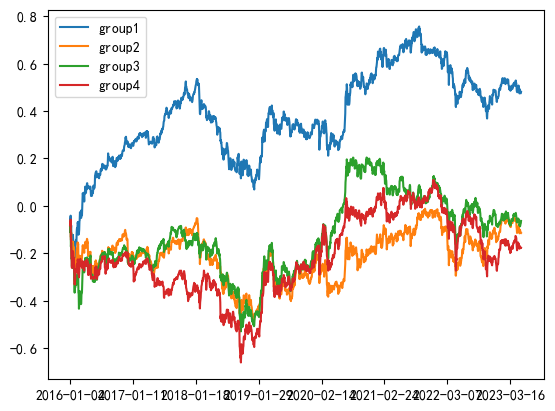

In [409]:
# 分组收益率
xy.cal_rate_group(
    New_ovn_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
).cumsum().plot()

#### 多头

shrh: 0.0 win%: 0.5179934569247546 gainloss%: -1.0500771309914925
shrh: 0.2 win%: 0.5184331797235023 gainloss%: -1.0457987586226194
shrh: 0.4 win%: 0.5264452644526445 gainloss%: -1.0940243752413124
shrh: 0.6 win%: 0.5328947368421053 gainloss%: -1.0777997288470291
shrh: 0.8 win%: 0.524024024024024 gainloss%: -1.0639112829064319


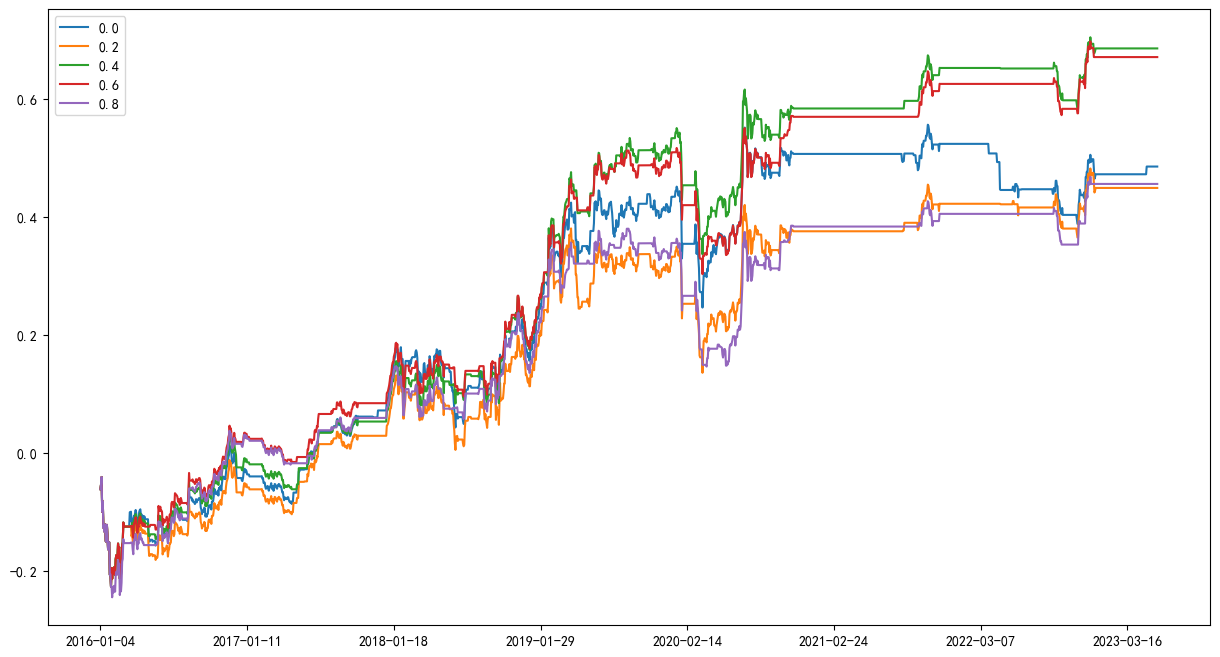

In [241]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]>i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
        
    # if i < 1.4:
    #     continue

    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    
    pd.Series(ts_ret.cumsum().rename(i),xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.8:
        break

In [238]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-01-05    0.007775
2016-01-07   -0.059137
2016-01-08    0.017896
2016-01-11   -0.044773
2016-01-12    0.005251
                ...   
2022-12-07   -0.005288
2022-12-08    0.000842
2022-12-12   -0.012118
2022-12-13    0.001107
2022-12-19   -0.015665
Name: 50, Length: 406, dtype: float64

#### 空头

shrh: 0.0 win%: 0.4976958525345622 gainloss%: -0.9456345567608521
shrh: 0.2 win%: 0.5036585365853659 gainloss%: -0.9324467286715544
shrh: 0.4 win%: 0.5065274151436031 gainloss%: -0.9112198314775933
shrh: 0.6 win%: 0.504297994269341 gainloss%: -0.9124547541108481


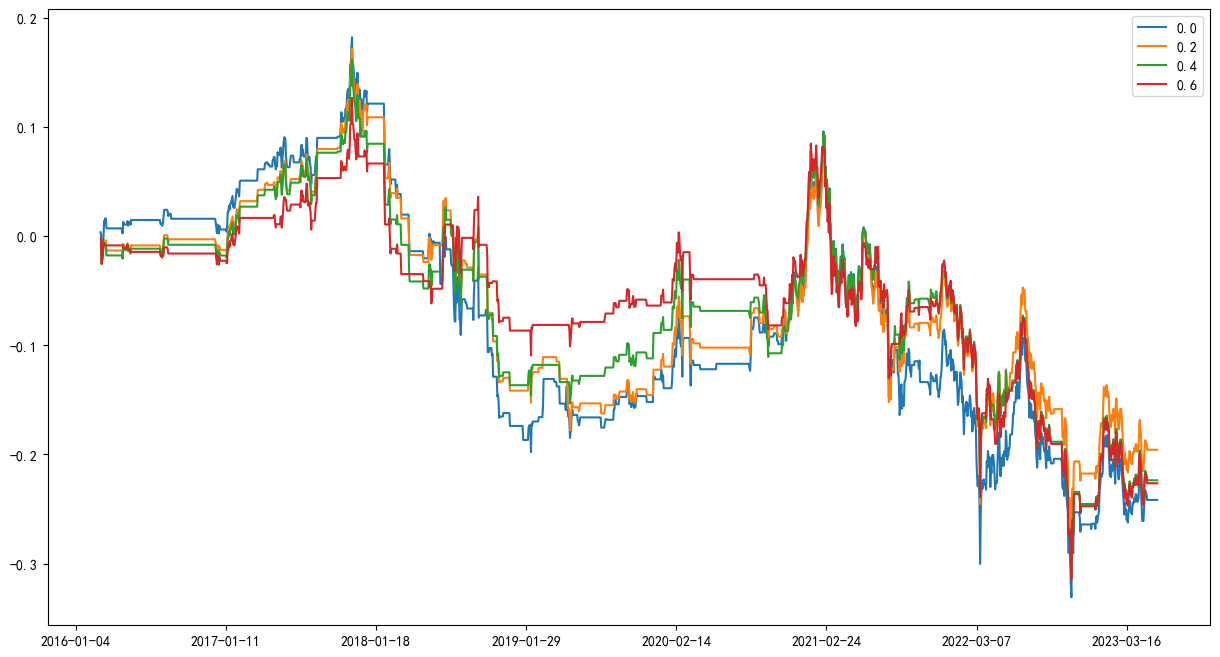

In [239]:
idx_name = '50'
for i in range(15)[::2]:
    i = i / 10
    same_dt = set(xy.Index_rets.T[idx_name].index) & set(New_TSR1_idx.T[idx_name].dropna().index)
    ts_ret = xy.Index_rets.T[idx_name].loc[New_TSR1_idx.T[idx_name][New_TSR1_idx.T[idx_name]<-i].index&same_dt]
    
    if len(ts_ret) < 1:
        continue
    
    
        
    win_pct = ts_ret[ts_ret>0].shape[0]/ts_ret.shape[0]
    win_loss_ratio = ts_ret[ts_ret>0].mean()/ts_ret[ts_ret<0].mean()
    print('shrh:',i, 'win%:', win_pct,'gainloss%:', win_loss_ratio)
    pd.Series(ts_ret.cumsum().rename(i), xy.Index_rets.T[idx_name].index).ffill().plot(legend=True,figsize=(15,8))
    
    if i == 0.6:
        break

In [240]:
ts_ret[ts_ret/ts_ret.shift()<0]

2016-03-11    0.004498
2016-03-17   -0.002175
2016-05-12    0.003092
2016-05-13   -0.004149
2016-08-02    0.000417
                ...   
2023-04-19   -0.008649
2023-04-25    0.000288
2023-04-26   -0.000479
2023-04-27    0.012449
2023-05-05   -0.002792
Name: 50, Length: 372, dtype: float64

## 评估

### cl-cl

-0.005304542389488867
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

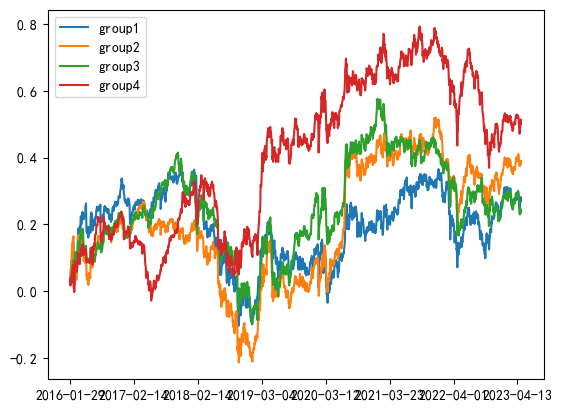

In [252]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR,
    xy.Index_rets,
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1200.0
yoy: 0.13930217658595143 
 mdd: -0.24263911959858697 
 sharpe: 0.8083180496890677 
 rankIC: 0.046514285714285716 
 rankIR: 0.060718360034692116 
 win%: 0.519327731092437 
 gain_loss%: -1.0222420349084191


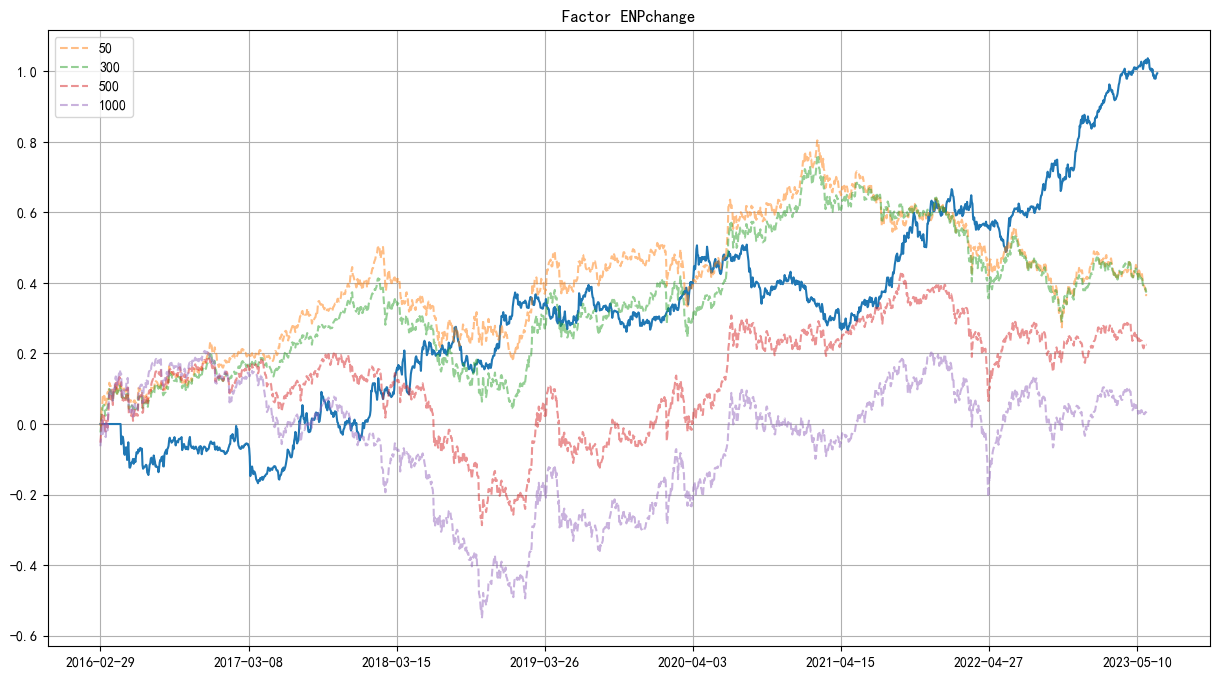

In [523]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx,
    xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

0.046514285714285716

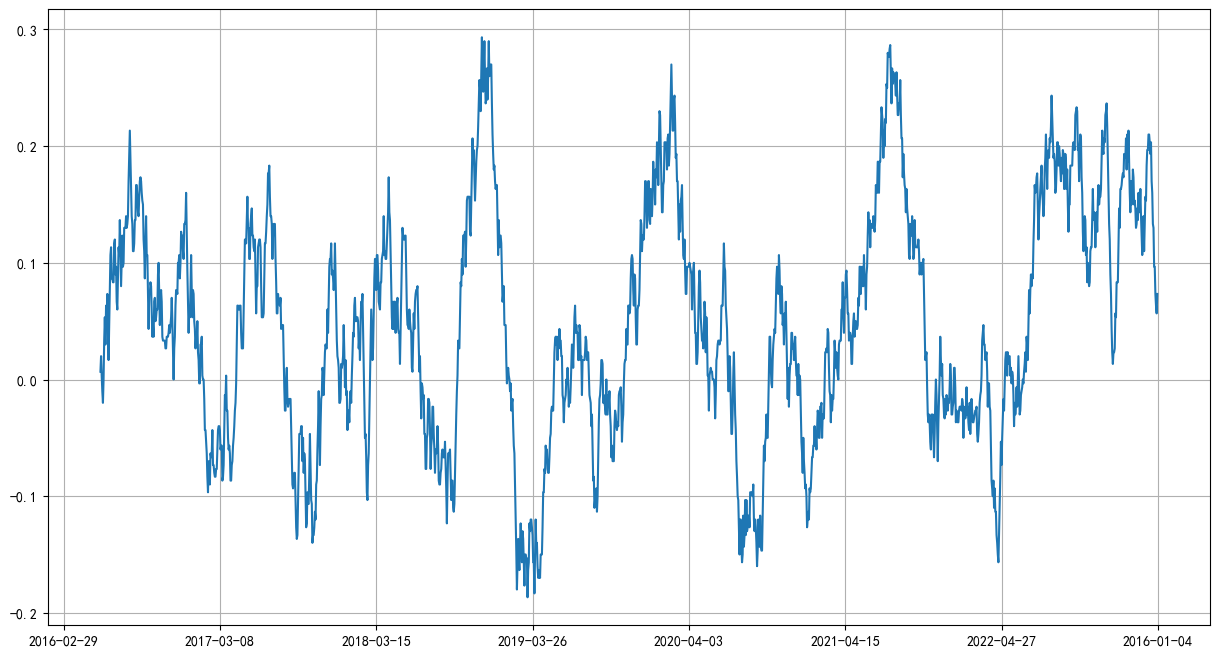

In [493]:
# 因子截面IC趋势
rankIC = xy.Index_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### cl_op

-0.05012971921705416
1 1.0
2 1.0
3 1.0
4 1.0


<Axes: >

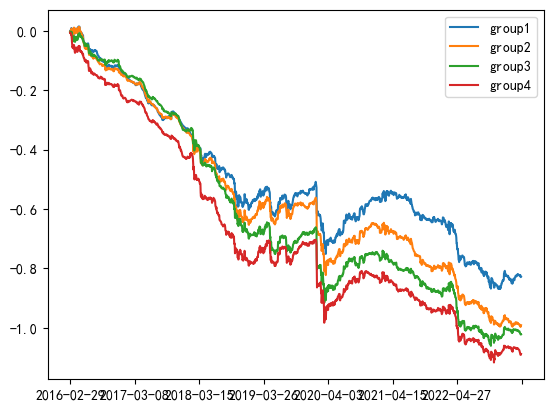

In [524]:
# 分组收益率
gr_ENPchange = xy.cal_rate_group(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    group_num=4,
    masks=1
)
gr_ENPchange.cumsum().plot()

1196.0
yoy: -0.037091003278173745 
 mdd: -0.31745989490437765 
 sharpe: -0.772221553049972 
 rankIC: -0.03474285714285715 
 rankIR: -0.0476398609918534 
 win%: 0.47314285714285714 
 gain_loss%: -0.9572870637371589


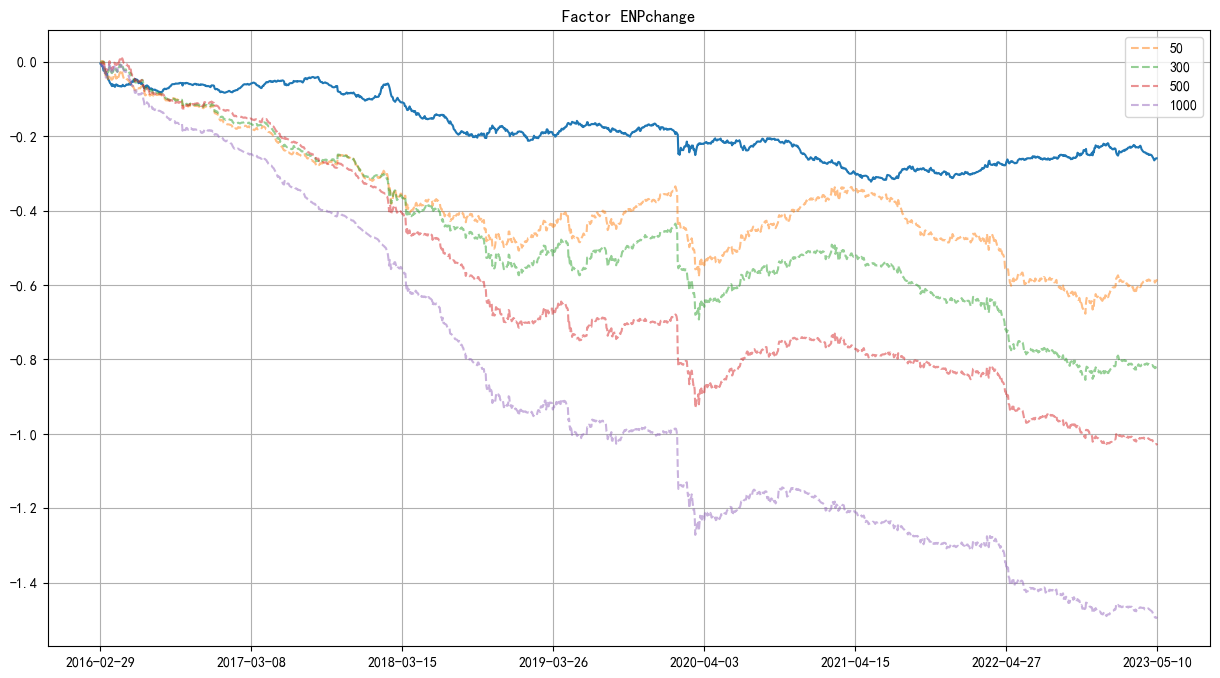

In [525]:
# 单因子强弱
ENPchange_select, ENPchange_rets = xy.single_Factor_backtest(
    New_TSR1_idx.T.rolling(1).mean().T.loc[['50', '300', '500', '1000'],'2016-02-28':],
    xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':],
    _side=1,
    fee=0.000,
    name='ENPchange'
)

-0.03474285714285715

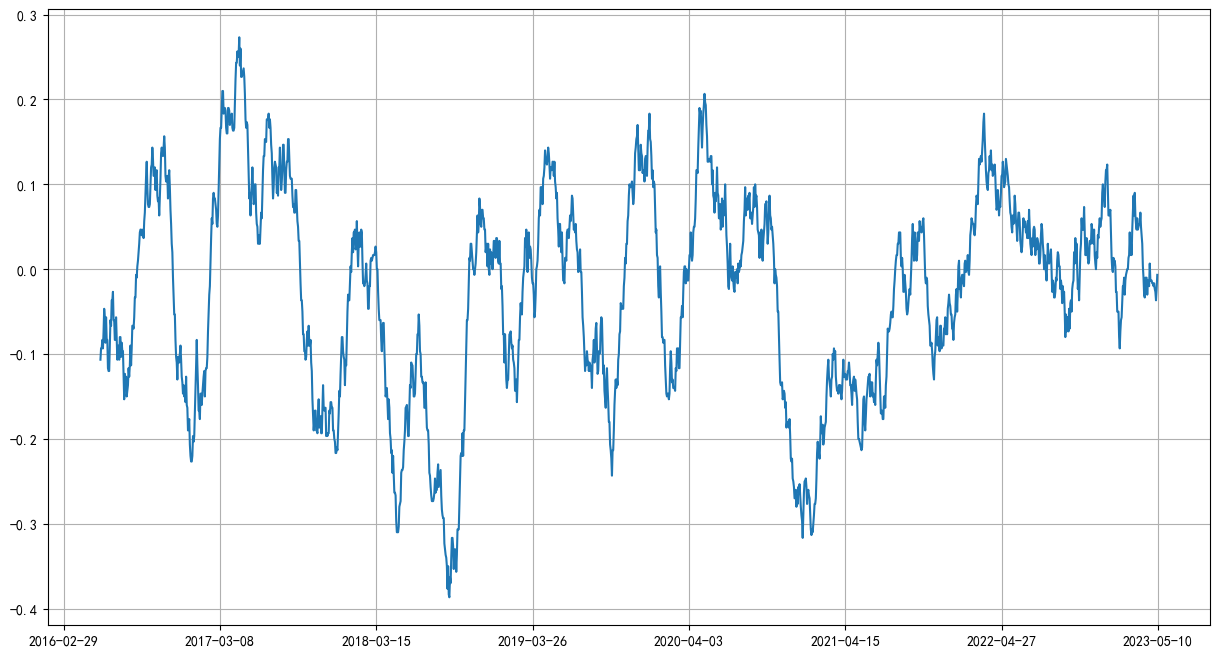

In [526]:
# 因子截面IC趋势
rankIC = xy.bonus_open_cl_rets.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False).corrwith(New_TSR1_idx.loc[['50', '300', '500', '1000'],'2016-02-28':].rank(ascending=False))
rankIC.rolling(60).mean().plot(figsize=(15,8),grid=1)
rankIC.mean()

### 择时

In [311]:
New_TSR

,2016-01-29,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-15,2016-02-16,2016-02-17,2016-02-18,...,2023-04-21,2023-04-24,2023-04-25,2023-04-26,2023-04-27,2023-04-28,2023-05-04,2023-05-05,2023-05-08,2023-05-09
50,0.147235,0.226462,1.930968,1.764611,1.508440,1.616129,1.754330,1.857371,1.925839,1.925839,...,-0.373158,0.157809,-0.898556,-0.218572,0.507251,1.803494,2.533228,2.403438,2.283654,2.237313
300,-0.350651,-0.180354,1.422594,1.234912,1.238376,1.420999,1.132818,0.808581,0.548959,0.548959,...,0.329314,-0.386280,-0.323111,0.273875,-1.049272,-1.349483,-1.132364,-2.331592,-2.250266,-2.602437
500,0.305772,-0.170631,-1.830181,-0.871996,-0.627495,-0.971579,-0.864574,-2.158523,-2.045980,-2.045980,...,0.521820,0.278926,1.243249,-0.667052,0.253414,-0.787568,-1.161915,-0.249733,-0.459283,0.304789
1000,-0.102355,0.124523,-1.523380,-2.127528,-2.119321,-2.065549,-2.022574,-0.507429,-0.428817,-0.428817,...,-0.477975,-0.050455,-0.021582,0.611749,0.288606,0.333557,-0.238948,0.177887,0.425895,0.060335


<Axes: >

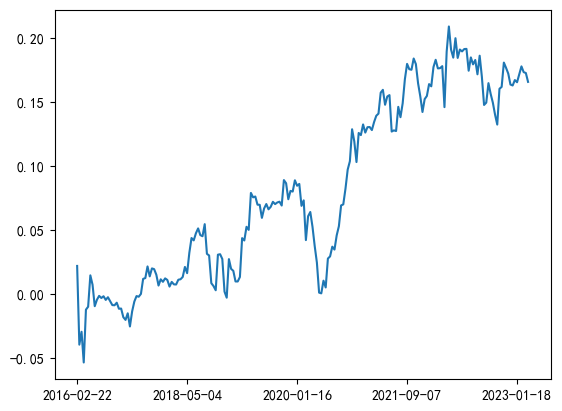

In [317]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']>1.5].index].cumsum().plot()

<Axes: >

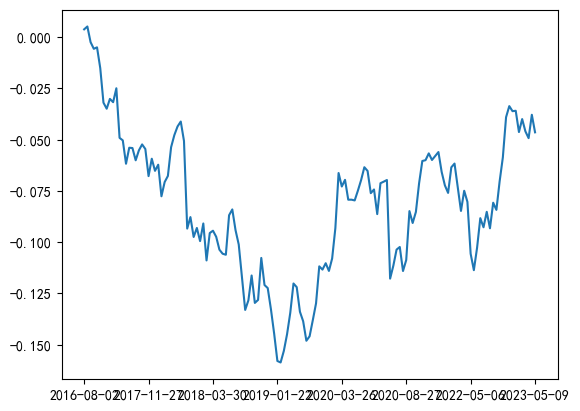

In [318]:
xy.Index_rets.T['300'].loc[New_TSR.T.dropna()['300'][New_TSR.T.dropna()['300']<-1.5].index].cumsum().plot()

In [249]:
New_TSR1_idx.to_csv(r'E:\PyProject\factors\NewFactor\st_TNR.csv')

In [250]:
New_TSR1_idx

,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,...,2023-04-21,2023-04-24,2023-04-25,2023-04-26,2023-04-27,2023-04-28,2023-05-04,2023-05-05,2023-05-08,2023-05-09
50,1.162610,1.178631,1.071053,1.074626,1.172423,1.285050,1.310740,1.336981,1.133745,1.127067,...,-1.403125,-1.293744,-1.175258,-1.489783,-1.418608,-1.378618,-1.321552,-0.932959,0.169829,-0.659408
300,0.279121,0.345265,0.455569,0.425751,0.317748,0.176470,0.047593,0.070889,0.265621,0.245809,...,0.334108,0.242778,0.428628,0.405793,0.106269,-0.044465,-0.009263,-0.164370,1.346187,-0.764973
500,-0.205534,-0.355443,-0.273406,-0.231368,-0.290028,-0.377569,-0.256579,-0.374990,-0.123074,-0.083570,...,0.117248,-0.072439,-0.387053,0.422912,0.416233,0.505567,0.236524,1.414836,-0.827962,1.407017
1000,-1.236198,-1.168453,-1.253216,-1.269009,-1.200143,-1.083950,-1.101754,-1.032880,-1.276292,-1.289307,...,0.951769,1.123405,1.133683,0.661078,0.896107,0.917517,1.094291,-0.317506,-0.688054,0.017364
